### Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
# import lightgbm as lgb
from sklearn.metrics import classification_report

import xgboost as xgb

# try
import xgboost as xgb

### Read data

In [2]:
os.listdir('./data-science-bowl-2019')

['train_labels.csv',
 '.DS_Store',
 'test.csv',
 'specs.csv',
 'train.csv',
 'sample_submission.csv']

In [3]:
%%time
root = './data-science-bowl-2019/'

keep_cols = ['event_id', 'game_session', 'installation_id', 'event_count', 'event_code', 'title', 'game_time', 'type','world']
train = pd.read_csv(root+'train.csv', usecols=keep_cols)
test = pd.read_csv(root+'test.csv', usecols=keep_cols)

train_labels = pd.read_csv(root + 'train_labels.csv')
specs = pd.read_csv(root + 'specs.csv')
sample_submission = pd.read_csv(root + 'sample_submission.csv')

CPU times: user 27.9 s, sys: 2.2 s, total: 30.1 s
Wall time: 28 s


### Exploration the data

In [4]:
print('Size of train data',train.shape)
print('Size of test data',test.shape)
print('Size of train_labels data',train_labels.shape)
print('Size of specs data',specs.shape)

Size of train data (11341042, 9)
Size of test data (1156414, 9)
Size of train_labels data (17690, 7)
Size of specs data (386, 3)


In [5]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
%%time
train = reduce_mem_usage(train,verbose=True)
test = reduce_mem_usage(test)
train_labels = reduce_mem_usage(train_labels)
specs = reduce_mem_usage(specs)

Mem. usage decreased to 605.68 Mb (22.2% reduction)
Mem. usage decreased to 61.76 Mb (22.2% reduction)
Mem. usage decreased to  0.49 Mb (48.2% reduction)
Mem. usage decreased to  0.01 Mb (0.0% reduction)
CPU times: user 1.07 s, sys: 393 ms, total: 1.46 s
Wall time: 282 ms


In [7]:
train.head()

,event_id,game_session,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [8]:
test.head()

,event_id,game_session,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [9]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [10]:
specs.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [11]:
train.dtypes.value_counts()

object    6
int16     2
int32     1
dtype: int64

In [12]:
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

event_id              384
game_session       303319
installation_id     17000
title                  44
type                    4
world                   4
dtype: int64

In [13]:
train_labels.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

game_session       17690
installation_id     3614
title                  5
dtype: int64

In [14]:
specs.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

event_id    386
info        168
args        191
dtype: int64

### Examine Missing Values

In [15]:
train_all = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing_train_data = pd.concat([train_all,percent], axis = 1, keys = ['Total','Percent'])

In [16]:
missing_train_data

,Total,Percent
world,0,0.0
type,0,0.0
title,0,0.0
game_time,0,0.0
event_code,0,0.0
event_count,0,0.0
installation_id,0,0.0
game_session,0,0.0
event_id,0,0.0


In [17]:
test.isnull().sum().sort_values(ascending = False)

world              0
type               0
title              0
game_time          0
event_code         0
event_count        0
installation_id    0
game_session       0
event_id           0
dtype: int64

In [18]:
train_labels.isnull().sum().sort_values(ascending = False)

accuracy_group     0
accuracy           0
num_incorrect      0
num_correct        0
title              0
installation_id    0
game_session       0
dtype: int64

In [19]:
specs.isnull().sum().sort_values(ascending = False)

args        0
info        0
event_id    0
dtype: int64

In [20]:
train.corr()

,event_count,event_code,game_time
event_count,1.000000,0.043830,0.142553
event_code,0.043830,1.000000,0.005257
game_time,0.142553,0.005257,1.000000


Text(0.5, 1, 'Correlation Heatmap')

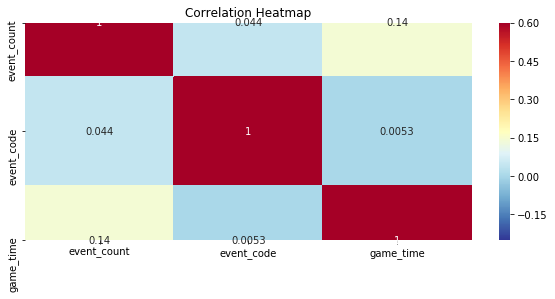

In [21]:
plt.figure(figsize=(10,4))
sns.heatmap(data=train.corr(), cmap=plt.cm.RdYlBu_r,vmin=-0.25, vmax=0.6, annot=True)
plt.title('Correlation Heatmap')

In [22]:
train_labels.corr()

,num_correct,num_incorrect,accuracy,accuracy_group
num_correct,1.000000,-0.417492,0.775638,0.840957
num_incorrect,-0.417492,1.000000,-0.593068,-0.573865
accuracy,0.775638,-0.593068,1.000000,0.988150
accuracy_group,0.840957,-0.573865,0.988150,1.000000


In [23]:
specs.corr()

""


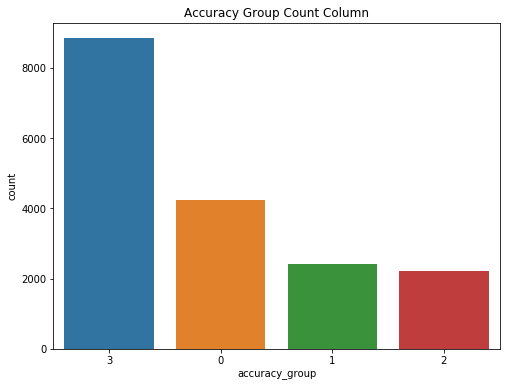

In [24]:
plt.figure(figsize=(8,6))
sns.countplot(x='accuracy_group',data=train_labels, order=train_labels['accuracy_group'].value_counts().index)
# plt.tight_layout()
plt.title('Accuracy Group Count Column')
plt.show()

In [25]:
palete = sns.color_palette(n_colors=10)

In [26]:
# type(train['game_time'].dtype.kind)

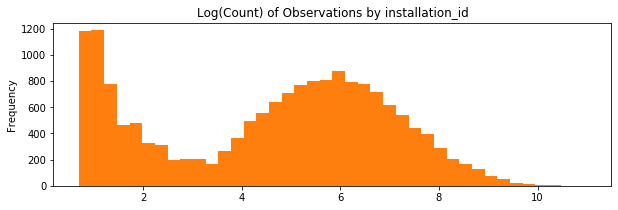

In [27]:
train.groupby('installation_id')['event_id'] \
    .count() \
    .apply(np.log1p) \
    .plot(kind='hist',
          bins=40,
          color=palete[1],
         figsize=(10, 3),
         title='Log(Count) of Observations by installation_id')
plt.show()

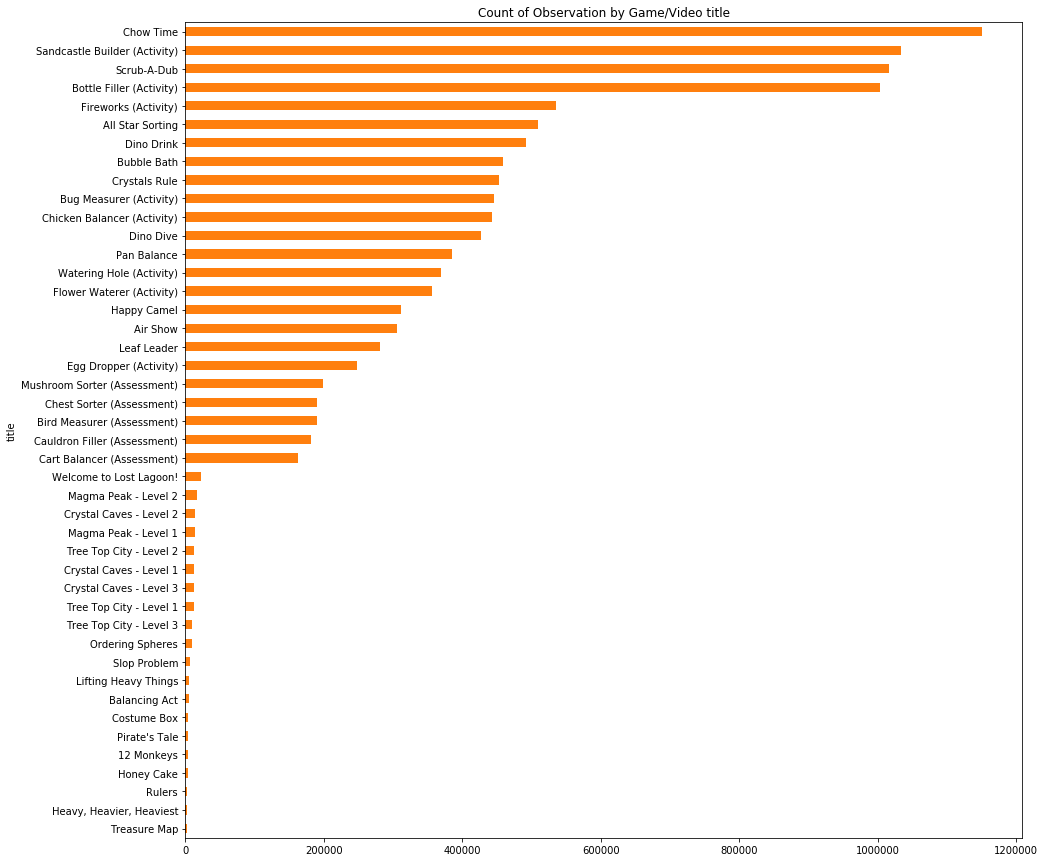

In [28]:
train.groupby('title')['event_id'].count().sort_values() \
    .plot(kind='barh',title='Count of Observation by Game/Video title',
         color=palete[1],
         figsize=(15,15))
plt.show()

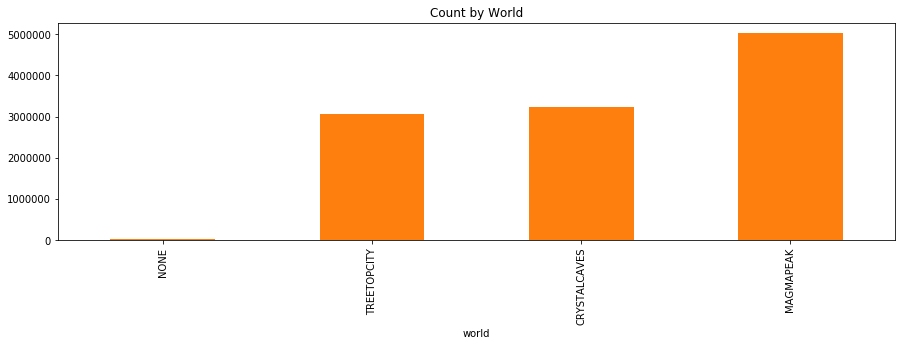

In [29]:
train.groupby('world')['event_id'] \
    .count() \
    .sort_values() \
    .plot(kind = 'bar', figsize = (15,4), title = 'Count by World', color = palete[1])
plt.show()

In [30]:
group1 = test.drop(columns=['event_id', 'event_code']).groupby(
        ['game_session', 'installation_id', 'title', 'type', 'world']
    ).max().reset_index()
group1

,game_session,installation_id,title,type,world,event_count,game_time
0,000326e9d4516dd0,48166507,Fireworks (Activity),Activity,TREETOPCITY,301,209785
1,0003a9881ca100aa,13a0754c,Flower Waterer (Activity),Activity,TREETOPCITY,96,152639
2,00094643cae0f886,a6f65253,12 Monkeys,Clip,TREETOPCITY,1,0
3,000ccfa39b7568d7,c42aeee6,Flower Waterer (Activity),Activity,TREETOPCITY,31,58317
4,001352e3c9cde9dd,7b728c89,Tree Top City - Level 2,Clip,TREETOPCITY,1,0
...,...,...,...,...,...,...,...
28440,fff27a9fe743447e,9bb426a7,Crystal Caves - Level 3,Clip,CRYSTALCAVES,1,0
28441,fff358902c51ffc5,87c15b6f,Ordering Spheres,Clip,TREETOPCITY,1,0
28442,fff5ac15aeb06eb2,7ff648d8,Scrub-A-Dub,Game,MAGMAPEAK,330,519404
28443,fff7c08e10a8caca,5d46e893,Lifting Heavy Things,Clip,CRYSTALCAVES,1,0


In [31]:
group3 = pd.get_dummies(group1.drop(columns=['game_session', 'event_count', 'game_time']),
            columns=['title', 'type', 'world']).groupby(['installation_id']).sum()
group3

,title_12 Monkeys,title_Air Show,title_All Star Sorting,title_Balancing Act,title_Bird Measurer (Assessment),title_Bottle Filler (Activity),title_Bubble Bath,title_Bug Measurer (Activity),title_Cart Balancer (Assessment),title_Cauldron Filler (Assessment),...,title_Watering Hole (Activity),title_Welcome to Lost Lagoon!,type_Activity,type_Assessment,type_Clip,type_Game,world_CRYSTALCAVES,world_MAGMAPEAK,world_NONE,world_TREETOPCITY
installation_id,,,,,,,,,,,,,,,,,,,,,
00abaee7,2.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,...,0.0,1.0,7.0,2.0,14.0,3.0,10.0,5.0,1.0,10.0
01242218,1.0,1.0,1.0,3.0,1.0,2.0,1.0,1.0,2.0,1.0,...,1.0,2.0,11.0,6.0,29.0,12.0,22.0,14.0,2.0,20.0
017c5718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,2.0,1.0,6.0,0.0,0.0,0.0,4.0,5.0
01a44906,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,2.0,1.0,10.0,1.0,0.0,0.0,3.0,11.0
01bc6cb6,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,3.0,1.0,1.0,17.0,6.0,12.0,3.0,3.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fee254cf,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,4.0,4.0,1.0,0.0,1.0,1.0,7.0
ff57e602,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,2.0,2.0,11.0,2.0,11.0,0.0,1.0,5.0
ffc73fb2,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,1.0,2.0,5.0,32.0,0.0,16.0,9.0,1.0,13.0


In [32]:
def compute_game_time_stats(group1, col):
    return group1[
        ['installation_id', col, 'event_count', 'game_time']
    ].groupby(['installation_id', col]).agg(
        [np.mean, np.sum, np.std]
    ).reset_index().pivot(
        columns=col,
        index='installation_id'
    )

In [33]:
compute_game_time_stats(group1, 'world')
# group1[
#         ['installation_id','world', 'event_count', 'game_time']].agg(
#         [np.mean, np.sum, np.std]
#     ).reset_index()

event_count                                           \
                        mean                                      sum   
world           CRYSTALCAVES  MAGMAPEAK NONE TREETOPCITY CRYSTALCAVES   
installation_id                                                         
00abaee7           25.300000  48.200000  1.0   37.300000        253.0   
01242218           40.227273  60.571429  1.0   49.200000        885.0   
017c5718                 NaN        NaN  1.0   29.200000          NaN   
01a44906                 NaN        NaN  1.0   21.000000          NaN   
01bc6cb6           43.500000   1.000000  1.0   60.571429        522.0   
...                      ...        ...  ...         ...          ...   
fee254cf                 NaN   1.000000  1.0   30.000000          NaN   
ff57e602           22.363636        NaN  1.0   11.200000        246.0   
ffc73fb2            9.625000  14.666667  1.0   18.384615        154.0   
ffe00ca8            1.000000  17.375000  1.0   22.800000          5.0   
ffe774cc                 NaN        NaN  NaN    9.000000          NaN   

                                                                    ...  \
                                                    std             ...   
world           MAGMAPEAK NONE TREETOPCITY CRYSTALCAVES  MAGMAPEAK  ...   
installation_id                                                     ...   
00abaee7            241.0  1.0       373.0    50.863761  65.614023  ...   
01242218            848.0  2.0       984.0    64.590971  52.988699  ...   
017c5718              NaN  4.0       146.0          NaN        NaN  ...   
01a44906              NaN  3.0       231.0          NaN        NaN  ...   
01bc6cb6              3.0  3.0       424.0    73.123184   0.000000  ...   
...                   ...  ...         ...          ...        ...  ...   
fee254cf              1.0  1.0       210.0          NaN        NaN  ...   
ff57e602              NaN  1.0        56.0    32.256078        NaN  ...   
ffc73fb2            132.0  1.0       239.0    34.500000  21.430119  ...   
ffe00ca8            139.0  1.0       114.0     0.000000  23.742292  ...   
ffe774cc              NaN  NaN        45.0          NaN        NaN  ...   

                game_time                                              \
                     mean                         sum                   
world                NONE    TREETOPCITY CRYSTALCAVES  MAGMAPEAK NONE   
installation_id                                                         
00abaee7              0.0  219048.700000     254255.0   279124.0  0.0   
01242218              0.0   45238.850000    1007630.0  1368643.0  0.0   
017c5718              0.0   22570.000000          NaN        NaN  0.0   
01a44906              0.0   17115.272727          NaN        NaN  0.0   
01bc6cb6              0.0   87235.000000     595933.0        0.0  0.0   
...                   ...            ...          ...        ...  ...   
fee254cf              0.0   47915.571429          NaN        0.0  0.0   
ff57e602              0.0   11539.400000     330218.0        NaN  0.0   
ffc73fb2              0.0   19165.846154     149031.0   132192.0  0.0   
ffe00ca8              0.0   14448.400000          0.0   113730.0  0.0   
ffe774cc              NaN    7321.400000          NaN        NaN  NaN   

                                                                             
                                      std                                    
world           TREETOPCITY  CRYSTALCAVES     MAGMAPEAK NONE    TREETOPCITY  
installation_id                                                              
00abaee7          2190487.0  47954.096461  83998.226634  NaN  612851.688038  
01242218           904777.0  76442.677704  95557.067745  0.0   60666.521390  
017c5718           112850.0           NaN           NaN  0.0   31069.926770  
01a44906           188268.0           NaN           NaN  0.0   32802.945447  
01bc6cb6           610645.0  78896.162035      0.000000  0.0  190602.380213

In [34]:
group4 = (
        group1[['installation_id', 'event_count', 'game_time']]
        .groupby(['installation_id'])
        .agg([np.sum, np.mean, np.std, np.min, np.max])
    )
group4

event_count                                 game_time  \
                        sum       mean        std amin amax       sum   
installation_id                                                         
00abaee7                868  33.384615  51.052974    1  159   2723866   
01242218               2719  46.879310  62.000871    1  230   3281050   
017c5718                150  16.666667  31.088583    1   72    112850   
01a44906                234  16.714286  34.212972    1  108    188268   
01bc6cb6                952  38.080000  83.317625    1  339   1206578   
...                     ...        ...        ...  ...  ...       ...   
fee254cf                212  23.555556  34.655848    1   92    335409   
ff57e602                303  17.823529  28.738553    1   79    387915   
ffc73fb2                526  13.487179  37.382709    1  182    530379   
ffe00ca8                259  13.631579  28.810127    1  110    185972   
ffe774cc                 45   9.000000  17.888544    1   41     36607   

                                                             
                          mean            std amin     amax  
installation_id                                              
00abaee7         104764.076923  381874.875578    0  1960630  
01242218          56569.827586   77980.940399    0   317027  
017c5718          12538.888889   24983.425223    0    60943  
01a44906          13447.714286   29678.814242    0    85983  
01bc6cb6          48263.120000  113848.826745    0   511237  
...                        ...            ...  ...      ...  
fee254cf          37267.666667   58118.494709    0   155008  
ff57e602          22818.529412   41309.477168    0   139394  
ffc73fb2          13599.461538   40986.235297    0   199825  
ffe00ca8           9788.000000   19663.608522    0    72242  
ffe774cc           7321.400000   16371.148090    0    36607  

[1000 rows x 10 columns]

In [35]:
world_time_stats = compute_game_time_stats(group1, 'world')
type_time_stats = compute_game_time_stats(group1, 'type')

In [36]:
group3.join(group4).join(world_time_stats).join(type_time_stats).fillna(0)

//anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
//anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 3 on the right)
  warnings.warn(msg, UserWarning)


,title_12 Monkeys,title_Air Show,title_All Star Sorting,title_Balancing Act,title_Bird Measurer (Assessment),title_Bottle Filler (Activity),title_Bubble Bath,title_Bug Measurer (Activity),title_Cart Balancer (Assessment),title_Cauldron Filler (Assessment),...,"(game_time, mean, Clip)","(game_time, mean, Game)","(game_time, sum, Activity)","(game_time, sum, Assessment)","(game_time, sum, Clip)","(game_time, sum, Game)","(game_time, std, Activity)","(game_time, std, Assessment)","(game_time, std, Clip)","(game_time, std, Game)"
installation_id,,,,,,,,,,,,,,,,,,,,,
00abaee7,2.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,...,0.0,761743.000000,408599.0,30038.0,0.0,2285229.0,36886.664956,21240.073493,0.0,1.038605e+06
01242218,1.0,1.0,1.0,3.0,1.0,2.0,1.0,1.0,2.0,1.0,...,0.0,118409.083333,1608843.0,251298.0,0.0,1420909.0,98521.245018,32761.743006,0.0,3.779781e+04
017c5718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,112850.0,0.0,0.0,0.0,6389.416875,0.000000,0.0,0.000000e+00
01a44906,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,77204.000000,111064.0,0.0,0.0,77204.0,43064.217188,0.000000,0.0,0.000000e+00
01bc6cb6,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,164146.666667,221698.0,0.0,0.0,984880.0,0.000000,0.000000,0.0,1.780426e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fee254cf,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,114921.000000,0.0,220488.0,0.0,114921.0,0.000000,68705.677713,0.0,0.000000e+00
ff57e602,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,112365.500000,127015.0,36169.0,0.0,224731.0,8217.287904,25575.345169,0.0,3.822407e+04
ffc73fb2,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.000000,264690.0,265689.0,0.0,0.0,95431.131189,56551.652060,0.0,0.000000e+00


In [37]:
def group_and_reduce(df):
    # group1 and group2 are intermediary "game session" groups,
    # which are reduced to one record by game session. group1 takes
    # the max value of game_time (final game time in a session) and 
    # of event_count (total number of events happened in the session).
    # group2 takes the total number of event_code of each type
    group1 = df.drop(columns=['event_id', 'event_code']).groupby(
        ['game_session', 'installation_id', 'title', 'type', 'world']
    ).max().reset_index()

    group2 = pd.get_dummies(
        df[['installation_id', 'event_code']], 
        columns=['event_code']
    ).groupby(['installation_id']).sum()

    # group3, group4 and group5 are grouped by installation_id 
    # and reduced using summation and other summary stats
    group3 = pd.get_dummies(
        group1.drop(columns=['game_session', 'event_count', 'game_time']),
        columns=['title', 'type', 'world']
    ).groupby(['installation_id']).sum()

    group4 = group1[
        ['installation_id', 'event_count', 'game_time']
    ].groupby(
        ['installation_id']
    ).agg([np.sum, np.mean, np.std])

    return group2.join(group3).join(group4)

In [38]:
train_to_use = group_and_reduce(train)
test_to_use = group_and_reduce(test)

In [39]:
print(train_to_use.shape)
print(train.shape)
print(train_labels.shape)

(17000, 100)
(11341042, 9)
(17690, 7)


In [40]:
# np.zeros((len(test_to_use), 4))+np.ones(len(test_to_use))

In [41]:
# train_to_use

### Train XGBM

In [45]:
%%time
from sklearn.model_selection import KFold
small_lables = train_labels[['installation_id', 'accuracy_group']].set_index('installation_id')
train_joined = train_to_use.join(small_lables).dropna()
kf = KFold(n_splits=5,random_state=2019)
x_train = train_joined.drop(columns = 'accuracy_group').values
# type(x_train)
y_train = train_joined['accuracy_group'].values.astype(np.int32)

y_preds = np.zeros((len(test_to_use),4))
xgb_preds = []
for train, val in kf.split(x_train):

    xgb_params = {
        'eta':0.2,
        'max_depth':4,
        'subsample':0.9,
        'objective': 'multi:softprob',
        'eval_metric':'mlogloss',
        'seed':99,
        'num_class':4
    }
    
    d_train = xgb.DMatrix(x_train[train],y_train[train])
    d_val = xgb.DMatrix(x_train[val],y_train[val])
    d_test = xgb.DMatrix(test_to_use.values)
    watch_list = [(d_train,'train'),(d_val,'valid')]
    model = xgb.train(xgb_params,d_train,5000,watch_list, verbose_eval=50, early_stopping_rounds=300)
    
    xgb_pred = model.predict(d_test)
    y_preds += xgb_pred
#     xgb_preds.append(list(xgb_pred))

[0]	train-mlogloss:1.30705	valid-mlogloss:1.31439
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 300 rounds.
[50]	train-mlogloss:0.967525	valid-mlogloss:1.07458
[100]	train-mlogloss:0.91986	valid-mlogloss:1.07821
[150]	train-mlogloss:0.892277	valid-mlogloss:1.08491
[200]	train-mlogloss:0.874473	valid-mlogloss:1.08628
[250]	train-mlogloss:0.861621	valid-mlogloss:1.09099
[300]	train-mlogloss:0.85327	valid-mlogloss:1.09883
[350]	train-mlogloss:0.846792	valid-mlogloss:1.10702
Stopping. Best iteration:
[78]	train-mlogloss:0.937394	valid-mlogloss:1.07044

[0]	train-mlogloss:1.3079	valid-mlogloss:1.3143
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 300 rounds.
[50]	train-mlogloss:0.965647	valid-mlogloss:1.07547
[100]	train-mlogloss:0.918885	valid-mlogloss:1.07242
[150]	train-mlogloss:0.893486	valid-mloglo

In [43]:
y_preds

array([[4.22672920e-01, 2.52771000e-02, 2.65425197e-02, 4.52550739e+00],
       [5.56232393e-01, 3.79324600e-01, 4.04977798e-01, 3.65946525e+00],
       [4.18232381e+00, 5.70611045e-03, 2.68868145e-02, 7.85083182e-01],
       ...,
       [1.29793811e+00, 5.89563750e-01, 7.78570630e-01, 2.33392751e+00],
       [3.34472299e+00, 4.81962316e-01, 4.73449942e-01, 6.99864775e-01],
       [5.02191097e-02, 1.55645938e-03, 2.11431027e-02, 4.92708129e+00]])

### Predict

In [46]:
%%time
y_pred = y_preds.argmax(axis=1)
test_to_use['accuracy_group'] = y_pred
test_to_use[['accuracy_group']].to_csv('submission.csv')

CPU times: user 6.14 ms, sys: 2.72 ms, total: 8.85 ms
Wall time: 10.3 ms


### Evaluation

In [47]:
%%time
val_preds = model.predict(d_val).argmax(axis = 1)
print(classification_report(y_train[val],val_preds))

              precision    recall  f1-score   support

           0       0.59      0.52      0.55       843
           1       0.44      0.09      0.15       504
           2       0.33      0.03      0.06       397
           3       0.59      0.87      0.70      1792

    accuracy                           0.58      3536
   macro avg       0.48      0.38      0.36      3536
weighted avg       0.54      0.58      0.51      3536

CPU times: user 59.8 ms, sys: 6.42 ms, total: 66.2 ms
Wall time: 9.95 ms
